In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
import time
import warnings
import gc, sys
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("yellow_tripdata_2019-06.csv")
print("There are " + str(len(data)) + " observations in the dataset.")
print("There are " + str(len(data.columns)) + " variables in the dataset.")

data.head()

There are 3936004 observations in the dataset.
There are 18 variables in the dataset.


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


In [3]:
#Reduce the data size to 1000000 records
data = data.head(1000000)

In [4]:
data = data[data['tip_amount'] > 0]
data = data[(data['tip_amount'] <= data['fare_amount'])]
data = data[((data['fare_amount'] >=2) & (data['fare_amount'] < 200))]
clean_data = data.drop(['total_amount'], axis=1)
print("There are " + str(len(clean_data)) + " observations in the dataset.")
print("There are " + str(len(clean_data.columns)) + " variables in the dataset.")

There are 682536 observations in the dataset.
There are 17 variables in the dataset.


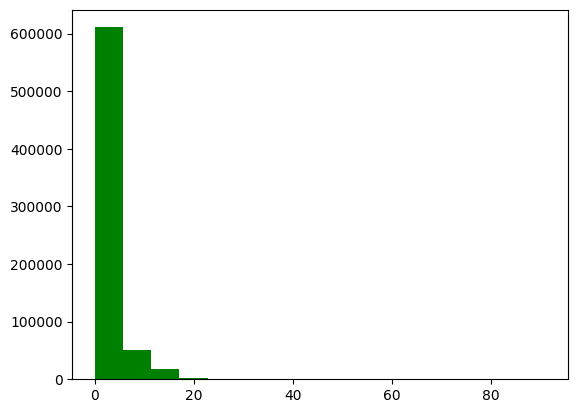

Minimum amount value is  0.01
Maximum amount value is  91.0
90% of the trips have a tip amount less or equal than  5.88


In [5]:
plt.hist(clean_data.tip_amount.values, 16, histtype='bar', facecolor='g')
plt.show()

print("Minimum amount value is ", np.min(clean_data.tip_amount.values))
print("Maximum amount value is ", np.max(clean_data.tip_amount.values))
print("90% of the trips have a tip amount less or equal than ", np.percentile(clean_data.tip_amount.values, 90))

In [6]:
clean_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5


In [7]:
#prepare data for training
clean_data['tpep_dropoff_datetime'] = pd.to_datetime(clean_data['tpep_dropoff_datetime'])
clean_data['tpep_pickup_datetime'] = pd.to_datetime(clean_data['tpep_pickup_datetime'])

# extract pickup and dropoff hour
clean_data['pickup_hour'] = clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour'] = clean_data['tpep_dropoff_datetime'].dt.hour

# extract pickup and dropoff day of week
clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday

# compute trip time in minutes
clean_data['trip_time'] = (clean_data['tpep_dropoff_datetime'] - clean_data['tpep_pickup_datetime']).astype('timedelta64[m]')

#drop the pickup and dropoff datetimes
clean_data = clean_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

In [8]:
#encode categorial features
get_dummy_col = ['VendorID','RatecodeID','store_and_fwd_flag','PULocationID','DOLocationID','payment_type','pickup_hour','dropoff_hour','pickup_day','dropoff_day']
proc_data = pd.get_dummies(clean_data, columns = get_dummy_col)

del clean_data
proc_data.head()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,trip_time,...,pickup_day_4,pickup_day_5,pickup_day_6,dropoff_day_0,dropoff_day_1,dropoff_day_2,dropoff_day_3,dropoff_day_4,dropoff_day_5,dropoff_day_6
4,1.0,1.70,9.5,3.0,0.5,2.65,0.0,0.3,2.5,12.0,...,0,1,0,0,0,0,0,0,1,0
5,2.0,1.60,9.5,3.0,0.5,1.00,0.0,0.3,2.5,10.0,...,0,1,0,0,0,0,0,0,1,0
7,2.0,1.20,7.5,3.0,0.5,1.00,0.0,0.3,2.5,8.0,...,0,1,0,0,0,0,0,0,1,0
9,1.0,8.60,31.5,3.0,0.5,7.05,0.0,0.3,2.5,34.0,...,0,1,0,0,0,0,0,0,1,0
10,1.0,1.74,11.0,0.5,0.5,2.96,0.0,0.3,2.5,14.0,...,0,1,0,0,0,0,0,0,1,0


In [9]:
#extract labels from dataframe
y = proc_data[['tip_amount']].values.astype('float32')

#drop the target variable from the feature matrix
proc_data = proc_data.drop(['tip_amount'], axis=1)

#get the feature matrix used for training
X = proc_data.values

#normalize the feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)

#print the shape of the features matrix and the labels vector
print('X.shape = ', X.shape, 'y.shape = ', y.shape)

X.shape =  (682536, 561) y.shape =  (682536, 1)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
#build a decision tree regressor model with scikit-learn
from sklearn.tree import DecisionTreeRegressor

sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=35)
t0 = time.time()
sklearn_dt.fit(X_train, y_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  41.24768


In [15]:
#build a decision tree regressor model with snap ml
from snapml import DecisionTreeRegressor

snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45, n_jobs=4)
t0 = time.time()
snapml_dt.fit(X_train, y_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  8.19690


In [16]:
#evaluate the scikit-learn and snap ml decision tree regressor models
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup: {0:.2f}x '.format(training_speedup))

#run inference using sklearn model
sklearn_pred = sklearn_dt.predict(X_test)

#evaluate the mean squared error on the test dataset
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score: {0:.3f}'.format(sklearn_mse))

#run inference using the snap ML model
snapml_pred = snapml_dt.predict(X_test)

#evaluate mean square error on the test dataset
snapml_mse = mean_squared_error(y_test, snapml_pred)
print('[Snap ML] MSE score: {0:.3f}'.format(snapml_mse))

[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup: 5.03x 
[Scikit-Learn] MSE score: 1.690
[Snap ML] MSE score: 1.675
